In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 5  # Bigger images
subject_details_path = '../files/SubjectDetails.xls'

subject_details_df = pd.read_excel(subject_details_path)
subject_details_df.head()

,S/No,Study Number,Height (cm),Weight (kg),Gender,PSG Start Time,PSG AHI,BMI,Age,Epworth Sleepiness Score,Study Duration (hr),Sleep Efficiency (%),Unnamed: 12,No of data blocks in EDF
0,1,UCDDB002,172,100.3,M,0:11:04,23,33.9,54,16,6.2,84,NaN,22470
1,2,UCDDB003,179,102.0,M,23:07:50,51,31.8,48,13,7.3,81,NaN,26478
2,3,UCDDB005,176,100.4,M,23:28:42,13,32.4,65,19,6.9,63,NaN,24798
3,4,UCDDB006,185,103.5,M,23:57:14,31,30.2,52,3,6.7,89,NaN,24267
4,5,UCDDB007,183,84.0,M,23:30:22,12,25.1,47,15,6.8,90,NaN,24405


I created a function that returns the signal by searching for its corresponding header.

In [2]:
from functools import reduce

def signal_for_header(signals, signal_headers, header):
    float_index = reduce(lambda prev,curr: curr[0] if curr[1] == header else prev, map(lambda elm: (elm[0],elm[1]['label']), enumerate(signal_headers)), 0)
    print(float_index)
    assert signal_headers[float_index]['label'] == header

    return np.array(signals[float_index])



This function is then used to get the nasal airflow signal from the first participant (`S/No 1`) 

In [3]:
subject_details_df[subject_details_df['S/No'] == 1]

,S/No,Study Number,Height (cm),Weight (kg),Gender,PSG Start Time,PSG AHI,BMI,Age,Epworth Sleepiness Score,Study Duration (hr),Sleep Efficiency (%),Unnamed: 12,No of data blocks in EDF
0,1,UCDDB002,172,100.3,M,0:11:04,23,33.9,54,16,6.2,84,NaN,22470


In [4]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf('../files/ucddb002.rec')
len(signals) == len(signal_headers) 
flow_signal_002 = signal_for_header(signals, signal_headers, 'Flow')

8


Find out the sample rate of our flow signal.

In [22]:
signal_headers[8]

{'label': 'Flow',
 'dimension': 'L/min',
 'sample_rate': 8.0,
 'sample_frequency': 8.0,
 'physical_max': 5.0,
 'physical_min': -5.0,
 'digital_max': 2047,
 'digital_min': -2048,
 'prefilter': 'HP:0.00 Hz      LP: 0.00 Hz',
 'transducer': 'FLOW'}

In [23]:
sample_rate = signal_headers[8]['sample_rate']

In [5]:
import os
import sys
THINKDSP_DIR = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'ThinkDSP/code'))
sys.path.append(THINKDSP_DIR)

This is the raw data from the first participant's nasal airflow channel.

<AxesSubplot:>

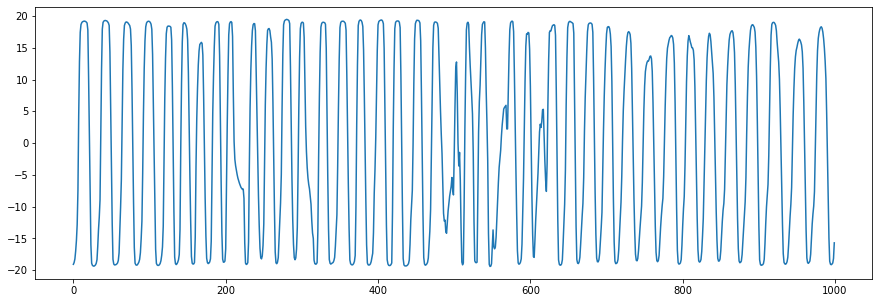

In [29]:
import thinkdsp
import seaborn as sns
mini_flow = flow_signal_002[:1000]
sns.lineplot(data=mini_flow)

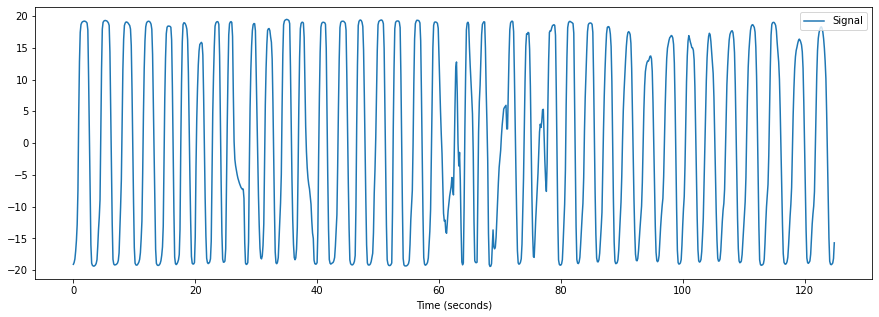

In [30]:
nk.signal_plot(mini_flow, sampling_rate=sample_rate)

In [32]:
cleaned = nk.rsp_clean(mini_flow, sampling_rate=sample_rate)
# Extract peaks
df, peaks_dict = nk.rsp_peaks(cleaned)
info = nk.rsp_fixpeaks(peaks_dict)
formatted = nk.signal_formatpeaks(info, desired_length=len(cleaned),peak_indices=info["RSP_Peaks"])

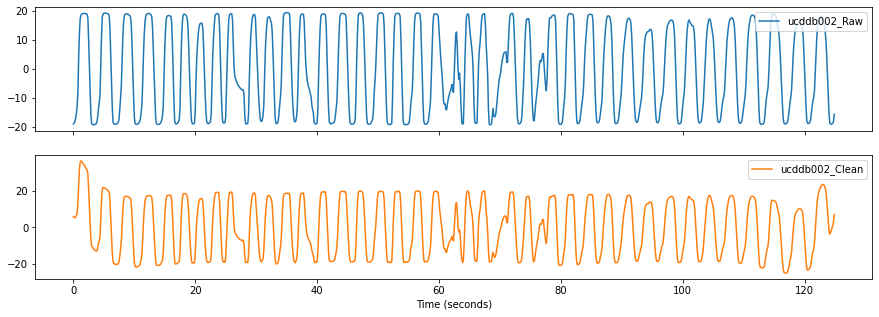

In [33]:
nk.signal_plot(pd.DataFrame({"ucddb002_Raw": mini_flow, "ucddb002_Clean": cleaned}), sampling_rate=sample_rate, subplots=True)

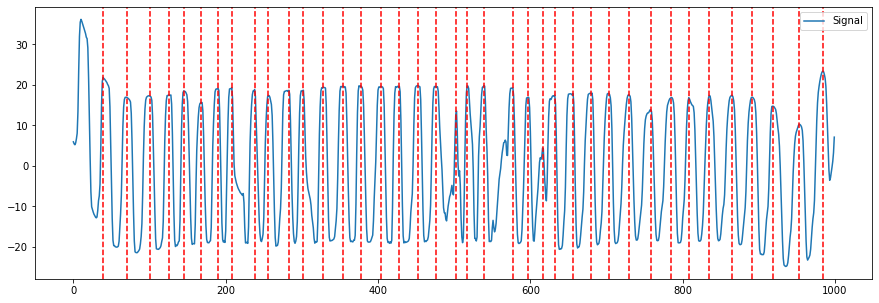

In [34]:
candidate_peaks = nk.events_plot(peaks_dict['RSP_Peaks'], cleaned)

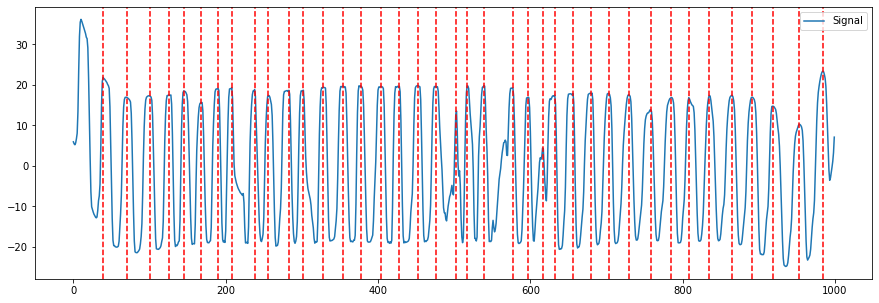

In [35]:
fixed_peaks = nk.events_plot(info['RSP_Peaks'], cleaned)

Text(0, 0.5, 'BPM')

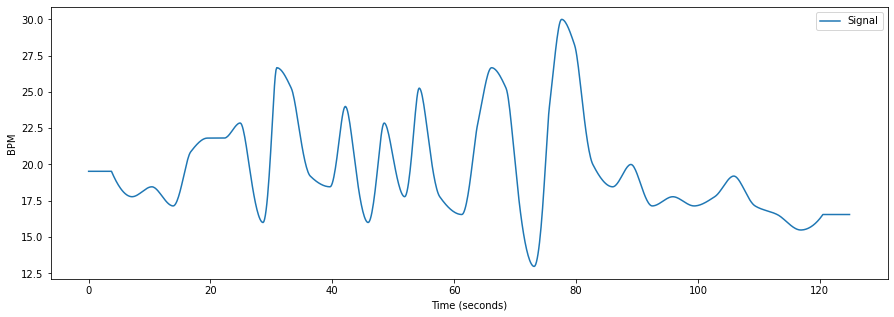

In [37]:
# Extract rate
rsp_rate = nk.rsp_rate(cleaned, peaks_dict, sampling_rate=sample_rate)

# Visualize
nk.signal_plot(rsp_rate, sampling_rate=sample_rate)
plt.ylabel('BPM')

,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,791.103403,3072.368421,582.422407,801.986437,0.189568,0.25749,3187.5,648.6375,0.203494,NaN,0.044732,0.005392,8.296637,NaN,NaN,567.090048,597.361364,1.05338,0.047536,inf


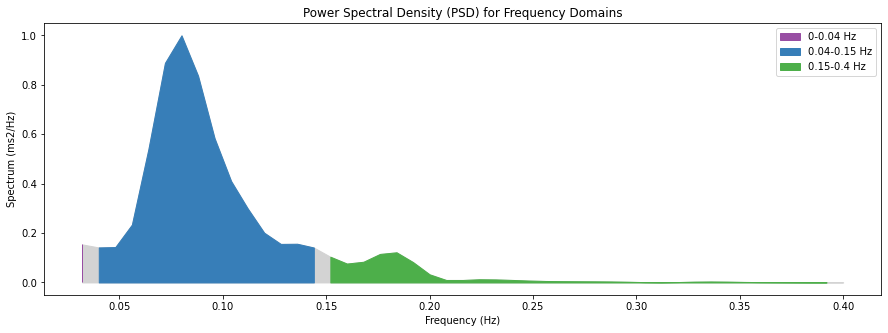

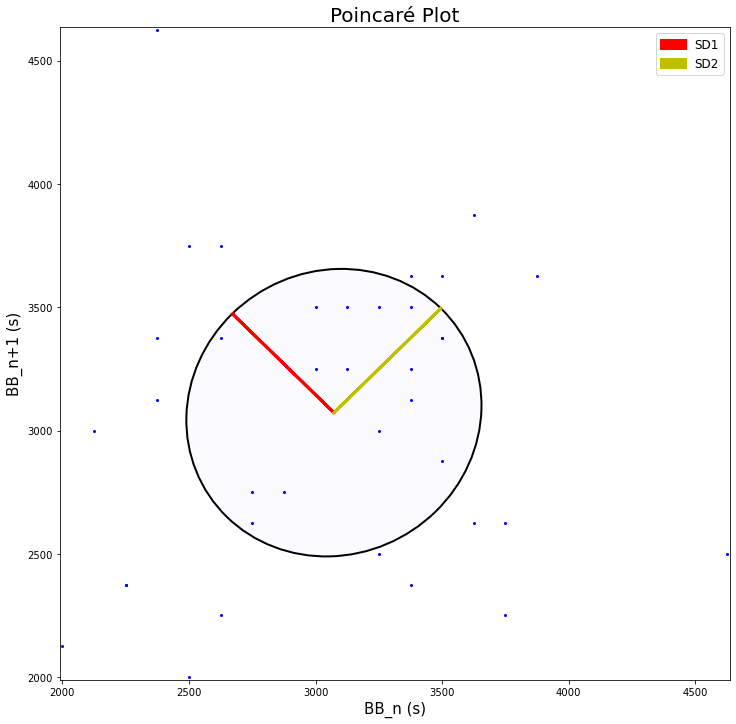

In [39]:
rrv = nk.rsp_rrv(rsp_rate, info, sampling_rate=sample_rate, show=True)
rrv

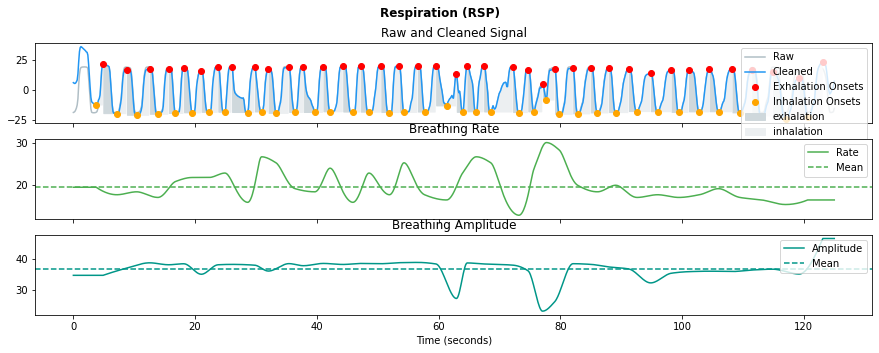

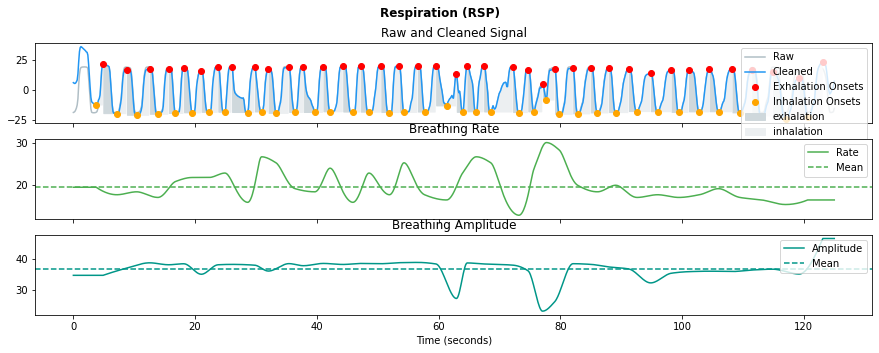

In [43]:
# Process it
signals, info = nk.rsp_process(mini_flow, sampling_rate=sample_rate)

# Visualise the processing
nk.rsp_plot(signals, sampling_rate=sample_rate)

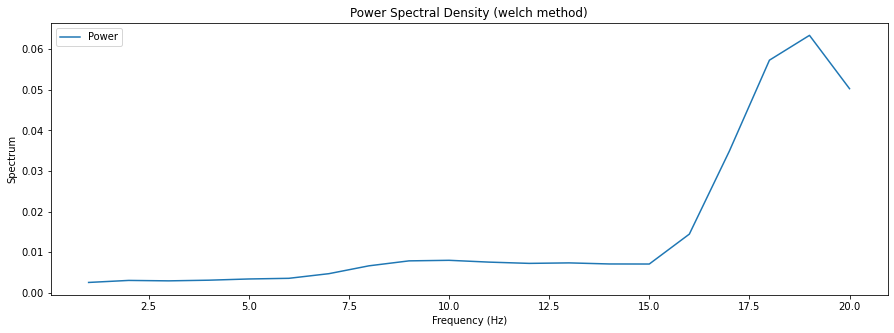

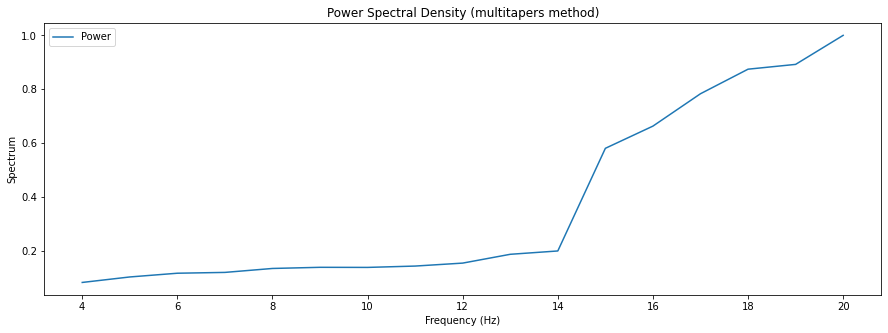

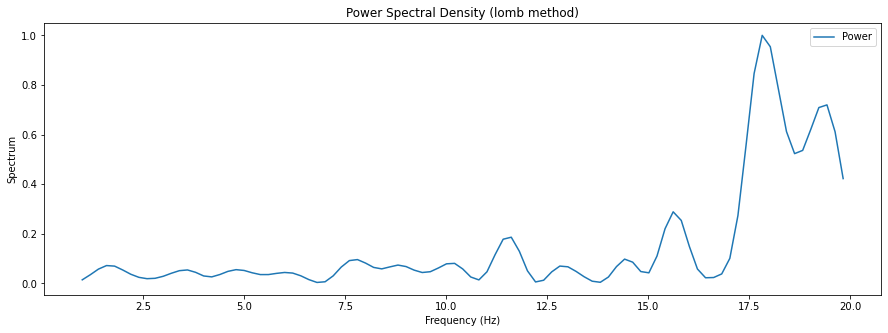

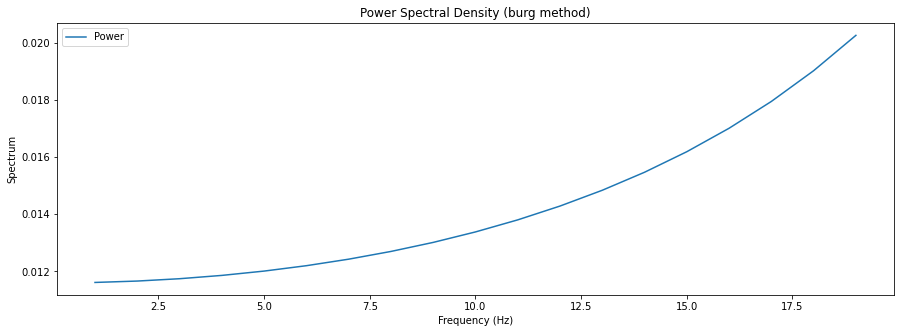

In [46]:
# Get the PSD using different methods
welch = nk.signal_psd(mini_flow, method="welch", min_frequency=1, max_frequency=20, show=True)
multitaper = nk.signal_psd(mini_flow, method="multitapers", max_frequency=20, show=True)
lomb = nk.signal_psd(mini_flow, method="lomb", min_frequency=1, max_frequency=20, show=True)
burg = nk.signal_psd(mini_flow, method="burg", min_frequency=1, max_frequency=20, order=10, show=True)

In [59]:
flow_df, info = nk.bio_process(rsp=mini_flow, sampling_rate=sample_rate)
results = nk.bio_analyze(flow_df, sampling_rate=sample_rate)


<AxesSubplot:>

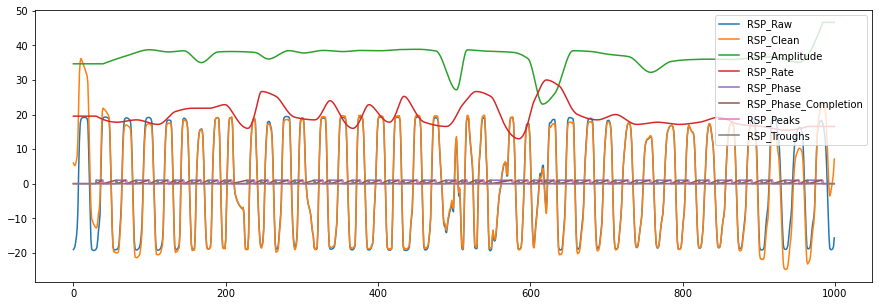

In [56]:
flow_df.plot()

In [60]:
# Half the data
results

,RSP_Rate_Mean,RSP_Amplitude_Mean,RSP_Phase_Duration_Inspiration,RSP_Phase_Duration_Expiration,RSP_Phase_Duration_Ratio,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,...,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,19.590494,36.717894,1.637821,1.203947,1.360376,791.103403,3072.368421,582.422407,801.986437,0.189568,...,0.044732,0.005392,8.296637,NaN,NaN,567.090048,597.361364,1.05338,0.047536,inf
